# **Ejercicio de Modelado de la Deserción en la Educación Superior Universitaria**

## 1. Importamos paquetes

In [1]:
import os
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import BaggingClassifier
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

## 2. Cargamos data

In [2]:
# create date (today)
hoy = datetime.datetime.today()
fecha = str(hoy.day).zfill(2)+str(hoy.month).zfill(2)+str(hoy.year)

# project working directory
ruta_proy = "D:/01_Trabajos/04_MINEDU_DIPODA/02_Actividades/04_Focalizacion/"
os.chdir(ruta_proy)
os.listdir('00_inputs')

# import data (after process in stata)
db = pd.read_stata('./00_inputs/base_outage_ebr2019.dta')
db.shape
columnas = db.columns.tolist()

## 3. Pre-procesamiento y definición de features y target

In [3]:
# pre-process
db_est = db.query("esu_o_egre==1")
db_est.estrato.value_counts()
db_est['urbano'] = np.where(db_est.estrato=='Urbano', 1, 0)
db_est['sm_ece'] = np.where((db_est.grupo_mm=='Satisfactorio') & (~db_est.puntaje_m.isna()), 1, 0)
db_est['sl_ece'] = np.where((db_est.grupo_ll=='Satisfactorio') & (~db_est.puntaje_l.isna()), 1, 0)
db_est['pobre'] = np.where(db_est.pobre=='No pobre', 0, 1)
db_est['urbano'] = np.where(db_est.estrato=='Urbano', 1, 0)
db_est['desertor'] = db_est.desertor.astype(int)
db_est.pobre.value_counts()


# features (main)
list_features = ['pobre', 'sm_ece', 'sl_ece', 'qnac100_2puntaje', 'qdep100_2puntaje', 'qprov100_2puntaje', 'qdist100_2puntaje']

# features (per)
list_feature_perc = ['qcol_95', 'qcol_96', 'qcol_97']

# target
target = ['desertor']

## 4. Simple EDA

In [4]:
db_est = db_est[target+list_features+list_feature_perc]

### A. Simple stats

In [5]:
db_est.describe().T

,count,mean,std,min,25%,50%,75%,max
desertor,97478.0,0.139724,0.346702,0.0,0.0,0.0,0.0,1.0
pobre,97478.0,0.244578,0.429839,0.0,0.0,0.0,0.0,1.0
sm_ece,97478.0,0.262798,0.440156,0.0,0.0,0.0,1.0,1.0
sl_ece,97478.0,0.322719,0.467519,0.0,0.0,0.0,1.0,1.0
qnac100_2puntaje,97478.0,62.104076,27.817022,1.0,41.0,67.0,86.0,100.0
qdep100_2puntaje,97478.0,61.146534,27.927097,1.0,39.0,66.0,86.0,100.0
qprov100_2puntaje,97478.0,60.828648,27.870945,1.0,39.0,65.0,85.0,100.0
qdist100_2puntaje,97478.0,59.858532,27.968468,1.0,38.0,64.0,84.0,100.0
qcol_95,97478.0,0.105778,0.307554,0.0,0.0,0.0,0.0,1.0
qcol_96,97478.0,0.091826,0.288781,0.0,0.0,0.0,0.0,1.0


In [6]:
db_est.isnull().mean()

desertor             0.0
pobre                0.0
sm_ece               0.0
sl_ece               0.0
qnac100_2puntaje     0.0
qdep100_2puntaje     0.0
qprov100_2puntaje    0.0
qdist100_2puntaje    0.0
qcol_95              0.0
qcol_96              0.0
qcol_97              0.0
dtype: float64

### B. Correlaciones

In [7]:
correlacion = db_est.corr(method = 'pearson')
correlacion

,desertor,pobre,sm_ece,sl_ece,qnac100_2puntaje,qdep100_2puntaje,qprov100_2puntaje,qdist100_2puntaje,qcol_95,qcol_96,qcol_97
desertor,1.000000,0.064905,-0.082439,-0.082875,-0.112589,-0.113499,-0.114207,-0.106799,-0.048556,-0.043923,-0.041234
pobre,0.064905,1.000000,-0.059394,-0.115267,0.019324,0.040998,0.047343,0.059363,0.085218,0.085190,0.083232
sm_ece,-0.082439,-0.059394,1.000000,0.472354,0.319619,0.316621,0.315846,0.307365,0.190843,0.178181,0.163150
sl_ece,-0.082875,-0.115267,0.472354,1.000000,0.308019,0.300159,0.297750,0.285657,0.151716,0.138471,0.126586
qnac100_2puntaje,-0.112589,0.019324,0.319619,0.308019,1.000000,0.987184,0.981074,0.965534,0.384113,0.356293,0.327542
qdep100_2puntaje,-0.113499,0.040998,0.316621,0.300159,0.987184,1.000000,0.993772,0.976738,0.395766,0.367473,0.338178
qprov100_2puntaje,-0.114207,0.047343,0.315846,0.297750,0.981074,0.993772,1.000000,0.982995,0.402116,0.373538,0.344108
qdist100_2puntaje,-0.106799,0.059363,0.307365,0.285657,0.965534,0.976738,0.982995,1.000000,0.414523,0.385281,0.355275
qcol_95,-0.048556,0.085218,0.190843,0.151716,0.384113,0.395766,0.402116,0.414523,1.000000,0.924535,0.852523
qcol_96,-0.043923,0.085190,0.178181,0.138471,0.356293,0.367473,0.373538,0.385281,0.924535,1.000000,0.922110


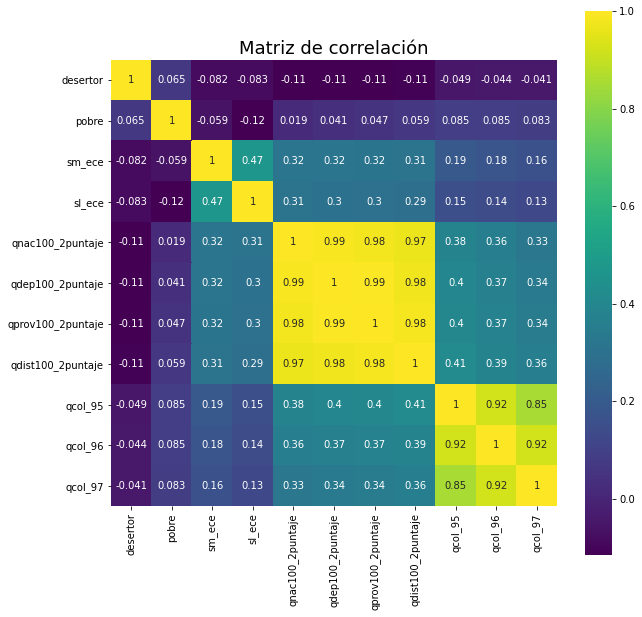

In [10]:
plt.figure(figsize=(10,10))
ax=sns.heatmap(correlacion,vmax=1,square=True,annot=True,cmap="viridis")
plt.title("Matriz de correlación", fontsize = 18)
plt.show()

### C. Density plots

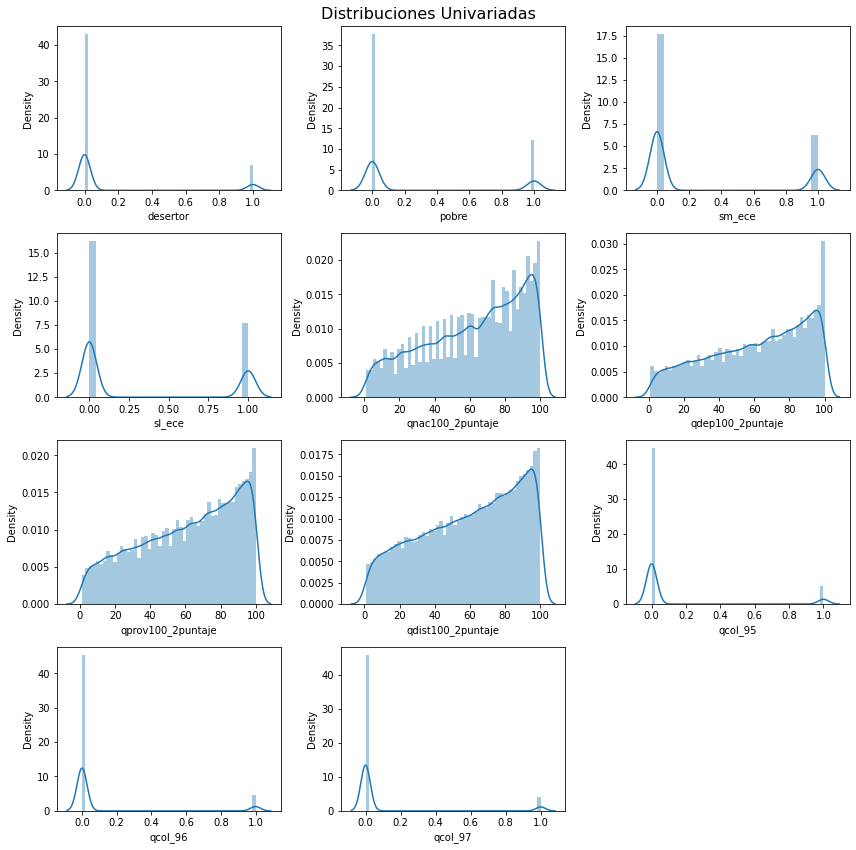

In [11]:
def generate_subplots(k, row_wise=False):
    nrow, ncol = math.ceil(k/3), 3
    figure, axes = plt.subplots(nrow, ncol, figsize=(12,12))
    
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        axes = axes.flatten(order=('C' if row_wise else 'F'))
        
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)            
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1
            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)
        axes = axes[:k]
        return figure, axes

names= db_est.columns.tolist()
figure, axes = generate_subplots(len(names), row_wise=True)
for n, ax in zip(names, axes):
    sns.distplot(db_est[n], ax = ax)
figure.suptitle('Distribuciones Univariadas', fontsize=16)
plt.tight_layout()
plt.show()

### D. Change scale

In [12]:
# change scale
var_chan = ['qnac100_2puntaje','qdep100_2puntaje','qprov100_2puntaje','qdist100_2puntaje']
db_est[var_chan] = db_est[var_chan].apply(lambda x: x/100)

## 5. Modelado

### A. Separar train y test

In [13]:
train, test = train_test_split(db_est, test_size=.2, random_state = 1)
def format_output(df,tar,q_n):
    data = df.copy(deep=True)
    target = data.pop(tar[0])
    target = np.array(target)
    if q_n == 'qcol_95':
        data.drop(columns=['qcol_96', 'qcol_97'], inplace=True)
    if q_n == 'qcol_96':
        data.drop(columns=['qcol_95', 'qcol_97'], inplace=True)
    if q_n == 'qcol_97':
        data.drop(columns=['qcol_95', 'qcol_96'], inplace=True)          
    return (target, data)

### B. Separar features y targets

In [14]:
# data para clasificación
train_Yclas, train_Xclas = format_output(train,tar=target,q_n='qcol_95')
test_Yclas, test_Xclas   = format_output(test,tar=target,q_n='qcol_95')

In [15]:
train.desertor.value_counts()

0    67085
1    10897
Name: desertor, dtype: int64

### C. Generar un pipeline

In [16]:
classifiers = [('nothing', Pipeline([('model', LogisticRegression())])),
               ('cost-sensitive', Pipeline([('model', LogisticRegression(class_weight='balanced'))])),
               ('over-sampling', Pipeline([('sampler', RandomOverSampler(random_state=0)), ('model', LogisticRegression())])),
               ('under-sampling', Pipeline([('sampler', RandomUnderSampler(random_state=0)), ('model', LogisticRegression())])),
               ('ensemble', Pipeline([('sampler', RandomUnderSampler(random_state=0)), ('model', BaggingClassifier(base_estimator = LogisticRegression(), n_estimators=10,
                        random_state=0))]))]

Percentil qcol_95
nothing score: 0.860
 
Percentil qcol_95
cost-sensitive score: 0.569
 
Percentil qcol_95
over-sampling score: 0.568
 
Percentil qcol_95
under-sampling score: 0.566
 
Percentil qcol_95
ensemble score: 0.568
 
Percentil qcol_96
nothing score: 0.860
 
Percentil qcol_96
cost-sensitive score: 0.569
 
Percentil qcol_96
over-sampling score: 0.568
 
Percentil qcol_96
under-sampling score: 0.566
 
Percentil qcol_96
ensemble score: 0.567
 
Percentil qcol_97
nothing score: 0.860
 
Percentil qcol_97
cost-sensitive score: 0.570
 
Percentil qcol_97
over-sampling score: 0.568
 
Percentil qcol_97
under-sampling score: 0.566
 
Percentil qcol_97
ensemble score: 0.568
 


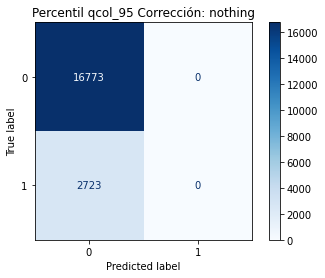

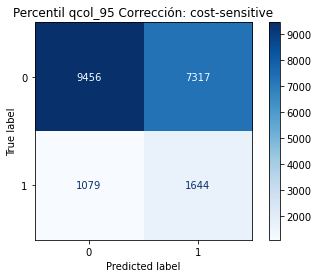

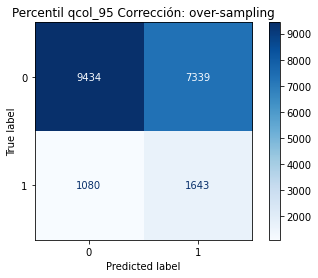

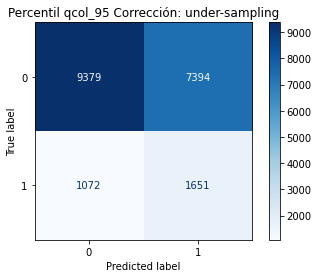

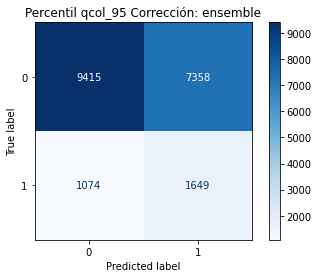

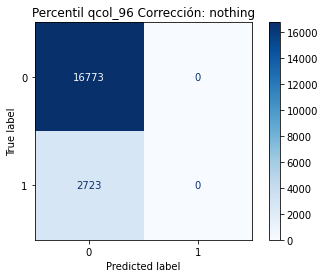

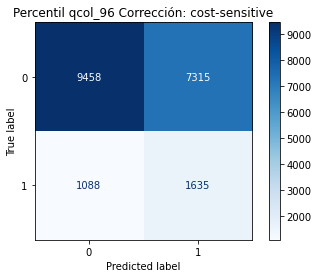

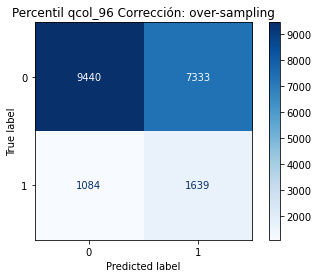

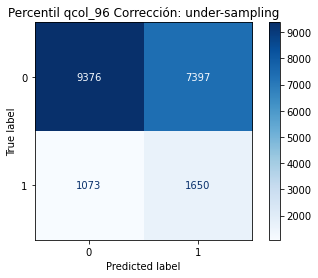

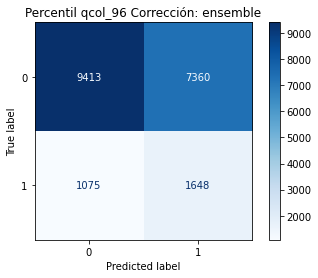

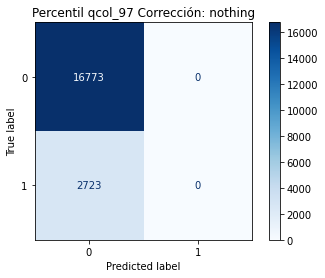

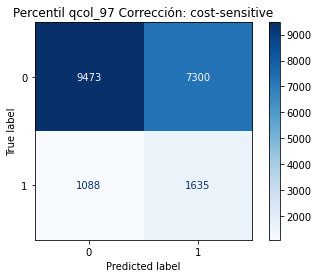

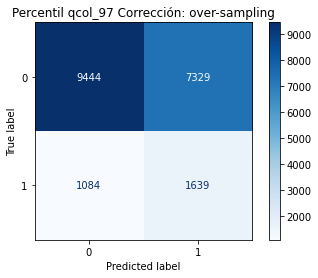

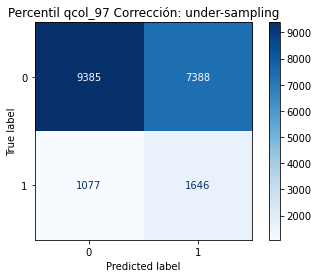

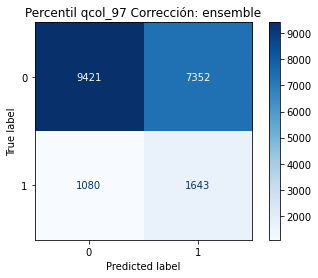

In [25]:
modeling_frame = pd.DataFrame()

for pc in list_feature_perc:
    train_Yclas, train_Xclas = format_output(train,tar=target,q_n=pc)
    test_Yclas, test_Xclas   = format_output(test,tar=target,q_n=pc)
    for tipo, model in classifiers:
        pipe = model.fit(train_Xclas, train_Yclas)
        print("Percentil " + pc)
        print(tipo + " score: %.3f" % pipe.score(test_Xclas, test_Yclas))
        print(" ")
        disp = plot_confusion_matrix(pipe, test_Xclas, test_Yclas, cmap="Blues")
        disp.ax_.set_title("Percentil "+pc+" Corrección: "+tipo)
        temp = pd.DataFrame(classification_report(test_Yclas, pipe.predict(test_Xclas), output_dict=True)).transpose()
        temp['metodo'] = tipo
        temp['percentil'] = pc
        modeling_frame = pd.concat([modeling_frame, temp])

In [26]:
modeling_frame = modeling_frame.reset_index()

In [27]:
modeling_frame

,index,precision,recall,f1-score,support,metodo,percentil
0,0,0.860330,1.000000,0.924922,16773.000000,nothing,qcol_95
1,1,0.000000,0.000000,0.000000,2723.000000,nothing,qcol_95
2,accuracy,0.860330,0.860330,0.860330,0.860330,nothing,qcol_95
3,macro avg,0.430165,0.500000,0.462461,19496.000000,nothing,qcol_95
4,weighted avg,0.740168,0.860330,0.795739,19496.000000,nothing,qcol_95
...,...,...,...,...,...,...,...
70,0,0.897153,0.561677,0.690841,16773.000000,ensemble,qcol_97
71,1,0.182657,0.603379,0.280423,2723.000000,ensemble,qcol_97
72,accuracy,0.567501,0.567501,0.567501,0.567501,ensemble,qcol_97
73,macro avg,0.539905,0.582528,0.485632,19496.000000,ensemble,qcol_97


In [28]:
modeling_frame.to_excel('./03_ouputs/Modelado_'+fecha+'.xlsx', index=False)